In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_mean_std_shaded, plot_mean_std_cap
import scienceplots
import orjson
plt.style.use(['science','no-latex'])

In [2]:
data_AR = np.genfromtxt(f'./results/AR_merged.csv', delimiter=',', skip_header=0, skip_footer=0)
data_ED = np.genfromtxt(f'./results/ED_merged.csv', delimiter=',', skip_header=0, skip_footer=0)
data_all = [data_AR, data_ED]

In [3]:
data_AR.shape, data_ED.shape

((200, 42), (200, 42))

In [4]:
def read_data(data):
    score = np.mean(data[:, 2::2], axis=-1)
    score_std = np.std(data[:, 2::2], axis=-1) / np.sqrt(data[:, 2:].shape[1] // 2)
    n_list = data[:, 0]
    dim_list = data[:, 1]
    return n_list, dim_list, score, score_std

In [12]:
n_select = [12, 16, 24, 32, 40]
marker_list = ['o', '^', 's', 'D', 'v', 'x']

[ 4  8 12 16 20 24] [0.972 0.951 0.943 0.937 0.916 0.889] [0.01022512 0.01337964 0.01436975 0.015059   0.01719267 0.01947011]


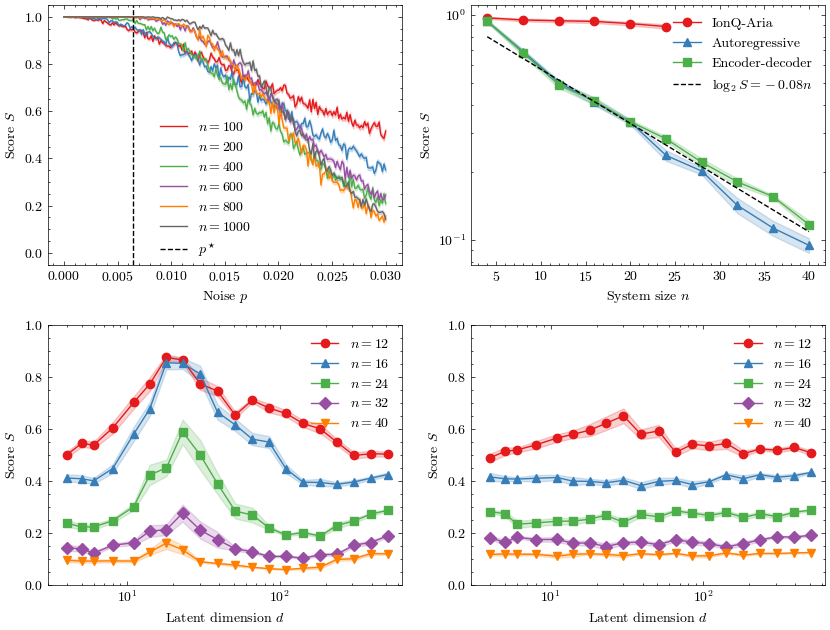

In [17]:
colors = plt.get_cmap('Set1')(np.arange(10))
colors[5] = plt.get_cmap('Dark2')(7)
fig, axes = plt.subplots(2, 2, figsize=(8.5, 6.5))

with open("noisy_quantum_model.json", "rb") as f:
    res = orjson.loads(f.read())
    # convert to numpy array
    res = {k: np.array(v) for k, v in res.items()}
n_list = [25, 50, 100, 150, 200, 250]
for i, n in enumerate(n_list):
    plot_mean_std_shaded(axes[0][0], res[str(n)][:, 0], res[str(n)][:, 1], res[str(n)][:, 2], color=colors[i], label=f"$n={4*n}$")
axes[0][0].vlines(1-(15/16)**(0.1), -0.05, 1.05, color='k', linestyle='--', label=r"$p^\star$")
axes[0][0].legend(loc=(0.3, 0))
axes[0][0].set_xlabel("Noise $p$")
axes[0][0].set_ylabel("Score $S$")
axes[0][0].set_ylim(-0.05, 1.05)

with open("aws.json", "rb") as f:
    data = orjson.loads(f.read())
    # convert to numpy array
    data = {k: np.array(v) for k, v in data.items()}

from magic_game import bit_to_num, check_answer
def check_input_output(inp, output, flatten=True):
    # inp {0, 1}
    length = len(inp)
    inp = bit_to_num(inp.reshape(-1, 2)).reshape(length, -1)
    inp1 = inp.reshape(length, 2, -1)[:, 0].reshape(-1)
    inp2 = inp.reshape(length, 2, -1)[:, 1].reshape(-1)
    out1 = output.reshape(length, 2, -1)[:, 0].reshape(-1, 2)
    out2 = output.reshape(length, 2, -1)[:, 1].reshape(-1, 2)
    # print(inp1, inp2, out1, out2)
    if flatten:
        return check_answer(inp1, inp2, out1, out2)
    return check_answer(inp1, inp2, out1, out2).reshape(length, -1)

n_aws = []
score_aws = []
std_aws = []
for i in range(6):
    check = check_input_output(data['input'], data['output'], flatten=False)[:, :i+1]
    score = np.mean(np.sum(check, axis=-1) > 0.95 * (i+1))
    std = 1.96 * np.sqrt(score * (1 - score) / len(check))
    score_aws.append(score)
    std_aws.append(std)
    n_aws.append(4*(i+1))
score_aws, std_aws, n_aws = np.array(score_aws), np.array(std_aws), np.array(n_aws)
print(n_aws, score_aws, std_aws)

plot_mean_std_shaded(axes[0][1], n_aws, score_aws, std_aws, color=colors[0], label=f"IonQ-Aria", marker=marker_list[0])

n_list, dim_list, score, score_std = read_data(data_all[0])
plot_mean_std_shaded(axes[0][1], 4 * n_list[dim_list == min(dim_list)], score[dim_list == min(dim_list)], score_std[dim_list == min(dim_list)], label=f'Autoregressive', marker=marker_list[1], color=colors[1])
n_list, dim_list, score, score_std = read_data(data_all[1])
plot_mean_std_shaded(axes[0][1], 4 * n_list[dim_list == min(dim_list)], score[dim_list == min(dim_list)], score_std[dim_list == min(dim_list)], label=f'Encoder-decoder', marker=marker_list[2], color=colors[2])
k = 0.08
axes[0][1].plot([4, 40], [2**(-k * 4), 2**(-k * 40)], 'k--', label=rf'$\log_2 S = -{k}n$')
axes[0][1].set_yscale('log')
axes[0][1].set_xlabel('System size $n$')
axes[0][1].set_ylabel('Score $S$')
axes[0][1].legend()

n_list, dim_list, score, score_std = read_data(data_all[0])
axes[1][0].set_xlabel('Latent dimension $d$')
axes[1][0].set_ylabel('Score $S$')
axes[1][0].set_ylim(0, 1.)
axes[1][0].set_xlim(3, 10**2.8)
axes[1][0].set_xscale('log')
ind = 0
for i in np.unique(n_list).astype(int):
    if 4 * i in n_select:
        plot_mean_std_shaded(axes[1][0], dim_list[n_list == i], score[n_list == i], score_std[n_list == i], color=colors[ind], label=f'$n = {4 * i}$', marker=marker_list[ind])
        ind += 1
axes[1][0].legend()

n_list, dim_list, score, score_std = read_data(data_all[1])
axes[1][1].set_xlabel('Latent dimension $d$')
axes[1][1].set_ylabel('Score $S$')
axes[1][1].set_ylim(0, 1.)
axes[1][1].set_xlim(3, 10**2.8)
axes[1][1].set_xscale('log')
ind = 0
for i in np.unique(n_list).astype(int):
    if 4 * i in n_select:
        plot_mean_std_shaded(axes[1][1], dim_list[n_list == i], score[n_list == i], score_std[n_list == i], color=colors[ind], label=f'$n = {4 * i}$', marker=marker_list[ind])
        ind += 1
axes[1][1].legend()

plt.tight_layout()

plt.savefig(f'./numerics.pdf')
plt.show()